# Rebalancing of shared micromobility services through dynamic pricing - Modelling
Prepared by Talha Alvi and Farhan Wadia

## Introduction
The purpose of this project is to show how the rebalancing problem for a shared micromobility service can be solved via a metaheuristic, bio-inspired, reinforcement learning algorithm. Refer to the data visualization notebook introduction for more description of this problem and how Bike Share Toronto (TBS) data is getting used. 

This notebook provides a description of the model, and the implementations of the Advantage Actor Critic (A2C) and Soft Actor Critic (SAC) reinforcement learning (RL) algorithms used for this problem. This notebook shows a small sample of training iterations and is intended to act as a reference guide since actual training and testing with over 100,000 iterations was initially done in separate Python scripts.

## Modelling Approach

The problem of solving the rebalancing problem via a dynamic pricing strategy can be formulated as a Markov Decision Process (MDP). The system consists of a series of states, transitions between those states, and a corresponding reward for each transition. The goal in this MDP formulation is to find a policy, i.e. a sequence of actions, that maximizes the expected reward over time.

The modelling approach below is adapted from [Pan et al.](https://arxiv.org/pdf/1802.04592.pdf)

### Environment
The environment is segmented spatially into a set of $N$ zones ${ Z = (z_1, z_2, ..., z_N)}$. The environment is segmented temporally into equal length, hourly timeslots $T = (1, 2, 3, ..., 24)$.

Let $S_i(t)$ be the supply of bikes at zone $i$ and time $t$ $\forall i \in N$ and $\forall t \in T$. Similarly, let $D_i(t)$ be the demand for bikes in zone $i$ in timeslot $t$, and $A_i(t)$ be the number of bikes arriving to zone $i$ in timeslot $t$.

Supply and demand dynamics at each zone $i$ are modelled in the MDP by assuming supply at the next timestep equals the supply at the current timestep, less the number of departures from zone $i$ at the current timestep, plus the number of arrivals to zone $i$ at the current timestep. Mathematically, this can be formed as:

$S_i(t+1) = S_i(t) -  \sum_{j = 1}d_{ij}(t) + \sum_{j=1} a_{ji}(t)$

where $d_{ij}(t)$ is a departure from zone $i$ to go to $j$ at timestep $t$, and $a_{ji}(t)$ is an arrival into zone $i$ from a trip that began at zone $j$. 

The environment also consists of a finite budget per day which can be used to provide incentives to users.

Therefore, the environment at each timestep can be modelled as $s(t) = (\textbf{S}(t), \textbf{D}(t-1), \textbf{ D}_f(t-1), B(t))$, where $\textbf{S}(t)$ represents the supply vector for the environment, $\textbf{D}(t-1)$ represents the demand vector at the previous time step, $\textbf{D}_f(t-1)$ represents the fulfilled demand vector at the previous time step and $B(t)$ represents the overall remaining budget.

### Action
The action of the model is to provide a monetary incentive (or no incentive) at each zone $i$ and timeslot $t$.

If a user is at a location and there is a bike available for them to use, no incentive is provided. If there is no bike available for a user $k$ at timeslot $t$, that user has their own cost $c_k(i, j, x)$ associated with the inconvenience of having to walk distance $x$ from their current zone $i$ to another neighbouring zone $j$. If there is no bike available in a neighbouring zone, then the user's cost is infinite. Mathematically, this can be formed as: 

$$c_k(i, j, x) = \begin{cases} 
\mbox{0,} & \mbox{if } i=j  \\
\alpha x^2 & \mbox{i and j are neighbouring zones} \\ 
+\infty & \mbox{otherwise} 
\end{cases}$$

For a user to accept an incentive, the incentive $p_{ij}(t)$ must be greater than or equal to $c_k(i, j, x)$. If the incentive provided is lower than the user's inconvenience cost, the trip will go unfulfilled.

The action is represented by $a(t) = (p_{1t}, p_{2t}, ... , p_{nt})$, which represents a sequence of incentive prices determined by the bike share operator. This is also considered as the agent that learns the optimal policy. 

### Reward & Objective
The agent receives some rewards $R(s_t, a_t)$, based on the state, action set, which is the number of trips that are fulfilled for the excess demand. 

The goal of this problem is to learn an optimal policy $\pi_\theta(s_t)$ that maps the state of the environment to an action that represents the best possible action for the given state. The policy shall maximize the overall discounted rewards starting from $s_0$ over some time horizon. The discount factor $\gamma \in [0, 1]$ represents the discount factor, which optimizes rewards over time, with 0 representing immediate reward and 1 representing rewards over an infinite horizon. 

# Implementation

In [3]:
import sys
import gym
from gym import spaces
import numpy as np
import matplotlib.pyplot as plt
import datetime
import requests

import random
import math
from itertools import product
from shapely.geometry import Point, Polygon
import pandas as pd


from copy import deepcopy
import geopandas as gpd
from stable_baselines3.common.env_checker import check_env
from stable_baselines3 import TD3, PPO, A2C, SAC, DDPG
from stable_baselines3.common.logger import configure
from stable_baselines3.common.noise import NormalActionNoise, OrnsteinUhlenbeckActionNoise


In [15]:
class BikeShareEnv(gym.Env):
    #time_step: timestep in minutes 
    #zone_size: edge size of square grid zone in metres to be used for balancing supply (recommend: 500 m)
    def __init__(self, data, size): 
        super(BikeShareEnv, self).__init__()
        self.time_step = 1 #step simulation time in hours 
        self.ride_data = data #dataframe containing bike share trip data for a month
        self.zone_size = size
        self.max_distance = 2000
        self.station_zones, self.zone_dict, self.zones = self.zone_division()
        self.num_zones = len(self.zone_dict) # number of zones in the environment 
        self.max_capacity = self.max_zone_capacity() #maximum capacity in each zone, numpy vector 
        self.zone_dist = self.find_zone_distance()
        self.max_budget = 3000.0

        #spaces
        self.action_space = spaces.Box(low=-2.5, high=2.5, shape=(self.num_zones,), dtype=np.float32)
        self.observation_space = spaces.Dict(
                            {'demand': spaces.Box(low=np.zeros(self.num_zones), high=self.max_capacity, shape=(self.num_zones,), dtype=np.float64), 
                              'fulfilled_demand': spaces.Box(low=np.zeros(self.num_zones), high=self.max_capacity, shape=(self.num_zones,), dtype=np.float64), 
                              'supply': spaces.Box(low=np.zeros(self.num_zones), high=self.max_capacity, shape=(self.num_zones,), dtype=np.float64),
                              'budget': spaces.Box(low =0 , high=self.max_budget, shape=(1,))
                            }) 
                        
        # #episode 
        self.max_length = 20 #hours in one day, 0 indexed
        self.curr_step = None
        self.done = None
        self.prev_supply = None
        self.reward_history = None
        self.history = None
        self.start_day = None
        self.reset()
        self.curr_budget = None
        self.total_step = None
        self.reward = None
        

    def reset(self, options=None):
        self.done = False
        self.curr_step = random.randrange(6, 20)
        self.reward_history = []
        self.history = []
        
        self.curr_budget = self.max_budget
        random_supply = self.initialize_random_supply() #randomly sample supply from the overall supply capacity
        obs = {
                'demand': np.zeros(self.num_zones), 
                'fulfilled_demand': np.zeros(self.num_zones), 
                'supply': random_supply,
                'budget': np.array(self.max_budget)
                }#
        
        self.prev_supply = random_supply
        self.delay_arrivals = np.zeros(self.num_zones)
        self.start_day = random.randrange(1, 30)
        self.reward = 0
        self.total_step = 0
        info = {}
        return obs

    def step(self, action):
        self.done = False

        if self.curr_step == self.max_length:
            self.curr_step = random.randrange(6, 20)
        if self.total_step == 24:
            self.reset()
            self.done = True
        res = sum(self.reward_history[-10:])

        self.total_step += 1

        demand = self.process_bike_demand()
        
        fulfilled_demand, extra_filled = self.find_fulfilled_demand(demand, action)
        

        self.reward = extra_filled
        self.reward_history.append(self.reward)
        updated_supply = np.subtract(self.prev_supply, fulfilled_demand)

        print('Step: ', self.total_step, 'Reward: ', self.reward, 'Demand: ', demand.sum(), 'Fulfill: ', fulfilled_demand.sum(), 'Supply: ', updated_supply.sum(), 'Budget: ', self.curr_budget)

        obs = {
                'demand': demand,
                'fulfilled_demand': fulfilled_demand,
                'supply': updated_supply,
                'budget': np.array(self.curr_budget)
                }
        arrivals = self.process_bike_arrivals(fulfilled_demand)
       # print('Arrivals: ', arrivals[200:210])

        fulfilled_arrivals = self.find_fulfilled_arrivals(arrivals)
       # print('Fuflilled Arrivals ', fulfilled_arrivals[200:210])
        
        self.prev_supply = np.add(self.prev_supply, fulfilled_arrivals) #Prev supply updated with fulfilled demand removed
        
        self.curr_step += self.time_step


        info = {'budget': self.curr_budget,
                'supply': updated_supply.sum(),
                'demand': demand.sum(), 
                'fulfilled': fulfilled_demand.sum()}
        self.history.append(self.reward)
        return obs, self.reward, self.done, info

    def render(self, mode="console"):
        if mode != 'console':
            raise NotImplementedError()        

    def close(self):
        pass
    
    def return_history(self):
        return self.history
    
    def find_fulfilled_demand(self, demand, action):
        #find fulfilled demand based on overall demand and user cost model 
        extra_demand = np.subtract(self.prev_supply, demand)
        lost_demand = np.zeros(self.num_zones)
        shifted_demand = np.zeros(self.num_zones)
        zone_dict_rev = {y: x for x, y in self.zone_dict.items()}
        demand_copy = deepcopy(demand)        
        for x in range(len(extra_demand)):
            if extra_demand[x] < 0:
                zon = zone_dict_rev[x]
                nearest_zones = deepcopy(self.zone_dist[zon])
                if len(nearest_zones) == 0: 
                    lost_demand[x] = abs(extra_demand[x]) #extra demand is lost if no nearby zones available
                else: 
                    filled = False
                    visited = []
                    extra = abs(extra_demand[x])
                    while extra > 0 and len(nearest_zones) > 0: 
                        nearest = min(nearest_zones, key=nearest_zones.get)
                        avail = extra_demand[self.zone_dict[nearest]]
                        if avail >= extra:
                            used = extra
                            extra = 0
                        elif avail > 0 and avail < extra:
                            used = avail 
                            extra = extra - avail
                        else: 
                            used = 0
                        visited.append([nearest, nearest_zones[nearest], used])
                        nearest_zones.pop(nearest)
                        
                    for y in range(len(visited)):
                        dist = visited[y][1]
                        user_accept = (2.26850903717*math.pow(10, -6)*(dist**2) - 0.000645645*dist + 0.84182) < (action[x] + 2.5) 
                        #bool value to check if user cost for the walking distance to the nearest zone is greater than the offered price
                        # if so, user rejects the offered price, since it offers negative utility. If user rejects, demand is lost.  
                        if user_accept and self.curr_budget > 0:
                            self.curr_budget = self.curr_budget - (5 - (action[x]+2.5))
                            shifted_demand[self.zone_dict[visited[y][0]]] += visited[y][2]
                        else:
                            lost_demand[x] += visited[y][2] 
                            
        for x in range(self.num_zones):
            if extra_demand[x] < 0:
                demand_copy[x] = demand_copy[x] + (extra_demand[x])

        fulfilled = np.add(demand_copy, shifted_demand)
        print('Lost: ', lost_demand.sum())
        
        return fulfilled, shifted_demand.sum() #fulfilled demand is overall demand subtracted by lost_demand

    def find_fulfilled_arrivals(self, arrivals):
        #finds fulfilled arrivals based on the nearest zones with available space. Arrivals are fulfilled if space is available. 
        arrival_capacity = np.subtract(self.max_capacity, self.prev_supply)
        extra_arrivals = np.subtract(arrival_capacity, arrivals)
        lost_arrivals = np.zeros(self.num_zones)
        shifted_arrivals = np.zeros(self.num_zones)
        zone_dict_rev = {y: x for x, y in self.zone_dict.items()}
        arrivals_copy = deepcopy(arrivals)        
        for x in range(len(extra_arrivals)):
            if extra_arrivals[x] < 0:
                zon = zone_dict_rev[x]
                nearest_zones = deepcopy(self.zone_dist[zon])
                if len(nearest_zones) == 0: 
                    lost_arrivals[x] = abs(extra_arrivals[x]) #extra demand is lost if no nearby zones available
                else: 
                    visited = []
                    extra = abs(extra_arrivals[x])
                    while extra > 0 and len(nearest_zones) > 0: 
                        nearest = min(nearest_zones, key=nearest_zones.get)
                        avail = extra_arrivals[self.zone_dict[nearest]]
                        if avail >= extra:
                            used = extra
                            extra = 0
                        elif avail > 0 and avail < extra:
                            used = avail 
                            extra = extra - avail
                        else: 
                            used = 0
                        visited.append([nearest, nearest_zones[nearest], used])
                        nearest_zones.pop(nearest)
                        
                    for y in range(len(visited)):
                        shifted_arrivals[self.zone_dict[visited[y][0]]] += visited[y][2] 
                            
        for x in range(self.num_zones):
            if extra_arrivals[x] < 0:
                arrivals_copy[x] = arrivals_copy[x] - abs(extra_arrivals[x])
        
        fulfilled = np.add(arrivals_copy, shifted_arrivals)
        
        return fulfilled

    def process_bike_arrivals(self, fulfilled_demand):
        #processes the bike arrivals from the provided dataset 
        dat = self.ride_data
        
        #convert dataframe to datetime objects
        dat['Start Time'] = pd.to_datetime(dat['Start Time'], format='%m/%d/%Y %H:%M')
        dat['End Time'] = pd.to_datetime(dat['End Time'], format='%m/%d/%Y %H:%M')

        #create start and end time for each timestep
        t_start = self.curr_step
        #t_end = self.curr_step + self.time_step
        start_step = pd.Timestamp(datetime.datetime(2022, 9, self.start_day, hour=t_start))
        end_step = pd.Timestamp(datetime.datetime(2022, 9, self.start_day, hour=t_start, minute=59))
        #mask for start time
        mask = (dat['Start Time'] >= start_step) & (dat['Start Time'] <= end_step)
        
        trips = {}
        for start_st, end_st in zip(dat['Start Station Id'].loc[mask], dat['End Station Id'].loc[mask]):
            if start_st in self.station_zones and end_st in self.station_zones:
                    start_zone = self.station_zones[start_st]
                    end_zone = self.station_zones[end_st]
                    start_ind = self.zone_dict[start_zone]
                    end_ind = self.zone_dict[end_zone]
                    if start_ind in trips:
                        if end_ind in trips[start_ind]:
                            trips[start_ind][end_ind] += 1
                        else:
                            trips[start_ind].update({end_ind: 1})
                    else:
                        trips[start_ind] = {end_ind: 1}

            for x in range(self.num_zones):
                if fulfilled_demand[x] > 0 and x in trips:
                    z = fulfilled_demand[x]
                    while z > 0 and sum(trips[x].values()) > 0:
                        for key in trips[x]:
                            if trips[x][key] == 0:
                                continue
                            trips[x][key] -=1
                            z -=1
                            if z == 0:
                                break        
            
            arrivals = np.zeros(self.num_zones)
            for x, y in trips.items():
                for a, b in trips[x].items():
                    arrivals[a] += b  
                
        return arrivals

    def zone_division(self):
        #divides stations into square zones and returns dictionaries for referencing statinos to zones
        response = requests.get("https://tor.publicbikesystem.net/ube/gbfs/v1/en/station_information/")
        stations = response.json()

        station = {}

        #get station id and corresponding geo coordinates
        for x in range(len(stations['data']['stations'])):
            station[int(stations['data']['stations'][x]['station_id'])] = [stations['data']['stations'][x]['lat'], stations['data']['stations'][x]['lon']]

        df = pd.DataFrame(station)

        df = df.transpose()

        #add station geometry into a geopandas data frame
        df.reset_index(inplace=True)
        df.set_axis(['station','lat', 'lon'], axis='columns', inplace=True)
        geometry = [Point(xy) for xy in zip(df.lon, df.lat)]
        df = df.drop(['lat', 'lon'], axis=1)
        gdf = gpd.GeoDataFrame(df, crs="EPSG:4326", geometry=geometry)
        gdf.to_crs(crs="EPSG:3857", inplace=True)

        #calculate bounds for the station coordinates to create a polygon containing all stations
        #split polygon into even square grid of zone_size x zone_size, geometry data stored in geopandas dataframe
        bounds = gdf.total_bounds
        x_coords = np.arange(bounds[0] + self.zone_size/2, bounds[2], self.zone_size)
        y_coords = np.arange(bounds[1] + self.zone_size/2, bounds[3], self.zone_size)
        combinations = np.array(list(product(x_coords, y_coords)))
        squares = gpd.points_from_xy(combinations[:, 0], combinations[:, 1]).buffer(self.zone_size / 2, cap_style=3)

        
        zones = gpd.GeoDataFrame(geometry=gpd.GeoSeries(squares), crs="EPSG:3857") #df containing coordinates for each zone

        
        zones_w_station = gpd.sjoin(zones, gdf, how='right') #all zones that contain at least one bike station
        station_zones = {}
        zone_list = []
        zones_w_station = zones_w_station.dropna(subset='index_left')
        
        for station, zone in zip(zones_w_station['station'], zones_w_station['index_left']):
            station_zones[station] = int(zone) #links each station id to a zone id 
            zone_list.append(int(zone))
        
        zone_list = sorted(list(set(zone_list)))
        
        zone_dict = {}
        for x in range(len(zone_list)):
            zone_dict[zone_list[x]] = x #a dict with each zone id corresponding to an index of 0 to num_zones

        return station_zones, zone_dict, zones
        
    def max_zone_capacity(self):
        #returns max zone_capacity as a vector indexed to each zone
        response = requests.get("https://tor.publicbikesystem.net/ube/gbfs/v1/en/station_information/")
        stations = response.json()

        station = {}

        #get max capacity for each station
        for x in range(len(stations['data']['stations'])):
            station[int(stations['data']['stations'][x]['station_id'])] = [stations['data']['stations'][x]['capacity']]

        max_capacity = np.zeros(self.num_zones)

        #calculate max capacity for each zone
        for key, val in station.items():
            if key in self.station_zones:
                zone = self.station_zones[key]
            max_capacity[self.zone_dict[zone]] += val 
        return max_capacity

    def initialize_random_supply(self):
        rand_supply = np.zeros(self.num_zones)
        for x in range(self.num_zones):
            y = max(1, self.max_capacity[x] - 0)
            rand_supply[x] = random.randrange(0, y)
        return rand_supply

    def process_bike_demand(self):
        dat = self.ride_data
        
        #convert dataframe to datetime objects
        dat['Start Time'] = pd.to_datetime(dat['Start Time'], format='%m/%d/%Y %H:%M')
        dat['End Time'] = pd.to_datetime(dat['End Time'], format='%m/%d/%Y %H:%M')

        #create start and end time for each timestep
        t_start = self.curr_step
        #t_end = self.curr_step + self.time_step
        start_step = pd.Timestamp(datetime.datetime(2022, 9, self.start_day, hour=t_start))
        end_step = pd.Timestamp(datetime.datetime(2022, 9, self.start_day, hour=t_start, minute=59))
        #mask for start time
        mask = (dat['Start Time'] >= start_step) & (dat['Start Time'] <= end_step)
        
        #add demand and arrivals to each zone for the chosen timestep
        demand_vec = np.zeros(self.num_zones)
        arrival_vec = np.zeros(self.num_zones)
        start_end = {}
        for start_st, end_st in zip(dat['Start Station Id'].loc[mask], dat['End Station Id'].loc[mask]):
            if start_st in self.station_zones and end_st in self.station_zones:
                start_zone = self.station_zones[start_st]
                demand_vec[self.zone_dict[start_zone]] +=1

        return demand_vec

    def find_zone_distance(self):
        #returns distance between each zone to all other zones as a dictionary. Only for distances less than max_distance.
        zone_dist = {}
        temp_dist = {}
        for a, b in self.zone_dict.items():
            a_point = self.zones['geometry'].loc[a].centroid
            for c, d in self.zone_dict.items():
                c_point = self.zones['geometry'].loc[c].centroid
                dist = a_point.distance(c_point)
                if dist < self.max_distance and a != c:
                    temp_dist[c] = int(dist)
            zone_dist[a] = temp_dist
            temp_dist = {}
        return zone_dist

### Model Training for SAC
Saves model as a zip file that can be loaded later and evaluated.

In [ ]:

tmp_path = "./tmp/"
new_logger = configure(tmp_path, ["stdout", "csv"])
data = pd.read_csv('./2022-09.csv')
env = BikeShareEnv(data, 300)
np.set_printoptions(suppress=True)
np.set_printoptions(precision=2)
n_actions = env.action_space.shape[-1]
action_noise = OrnsteinUhlenbeckActionNoise(mean=np.zeros(n_actions), sigma=1 * np.ones(n_actions))

model = SAC("MultiInputPolicy", env, learning_rate=0.00007, gamma=0.99, action_noise=action_noise,  batch_size=24, learning_starts=48,  tensorboard_log=tmp_path, verbose=1) 

model.set_logger(new_logger)
model.learn(total_timesteps=2000, log_interval=1, progress_bar=True, tb_log_name='log1')

model.save('sac_model')
del model


### Model Training for A2C

In [ ]:
tmp_path = "./tmp/"
new_logger = configure(tmp_path, ["stdout", "csv"])
data = pd.read_csv('./2022-09.csv')
env = BikeShareEnv(data, 300)
np.set_printoptions(suppress=True)
np.set_printoptions(precision=2)


model = A2C("MultiInputPolicy", env, learning_rate=0.0007, gamma=0.99,  tensorboard_log=tmp_path, verbose=1) #learning_rate=0.0003, action_noise=action_noise, gamma=0.49

model.set_logger(new_logger)
model.learn(total_timesteps=2000, log_interval=1, progress_bar=True, tb_log_name='log1')

model.save('a2c_model')
del model

#### Below code loads the provided model and evaluates it for a length of 7 days based on the provided data, only shown for SAC model. 

In [ ]:
env = BikeShareEnv(data, 300)
model = SAC.load("sac_model", env)
vec_env = model.get_env()
obs = vec_env.reset()

results = {'reward': [],
            'budget': [],
            'supply': [],
            'demand': [], 
            'fulfilled': []
            }
for i in range(168):
    action, _state = model.predict(obs, deterministic=True)
    obs, reward, done, info = vec_env.step(action)
    print(info)
    results['reward'].append(reward[0])
    results['budget'].append(info[0]['budget'])
    results['supply'].append(info[0]['supply'])
    results['demand'].append(info[0]['demand'])
    results['fulfilled'].append(info[0]['fulfilled'])

df = pd.DataFrame(results)
df.to_csv('results_sac_1.csv', encoding='utf-8', index=False)

## Training Results

The following section outlines the results of training the SAC and A2C models. 

Text(0.5, 1.0, 'A2C: Training Reward, Learing Rate = 0.0007')

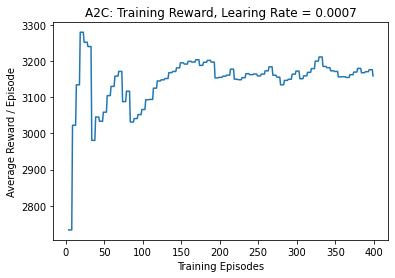

In [23]:
df = pd.read_csv("./logs/a2c_train_0.0007.csv")
mean_rew = df['rollout/ep_rew_mean']
plt.plot(mean_rew)
plt.xlabel('Training Episodes')
plt.ylabel('Average Reward / Episode')
plt.title('A2C: Training Reward, Learing Rate = 0.0007')

The above plot shows the training reward for the model. The model does start to eventually converge towards an average reward of around 3200 / episode, but takes a long time and still has quite a few swings as it is still attempting to learn an optimal policy. 

Text(0.5, 1.0, 'A2C: Value Loss, Learing Rate = 0.0007')

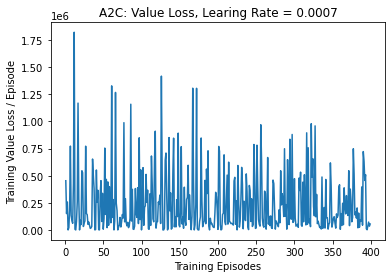

In [24]:
val_loss = df['train/value_loss']
plt.plot(val_loss)
plt.xlabel('Training Episodes')
plt.ylabel('Training Value Loss / Episode')
plt.title('A2C: Value Loss, Learing Rate = 0.0007')

The above figure shows the value loss from the training. As can be seen the value loss does go down over the length of training, but there is still huge swings in the actual value. This means that the model is not able to learn the optimal policy that well and the errors in the learned model will be high. 

Text(0.5, 1.0, 'SAC: Training Reward, Learing Rate = 0.0007')

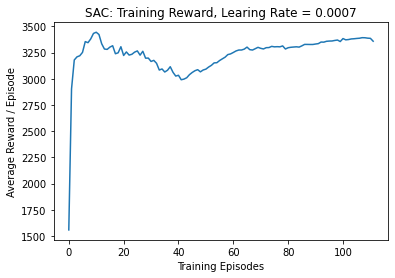

In [21]:
df = pd.read_csv("./logs/sac_train_0.0007_g_0.99.csv")
mean_rew = df['rollout/ep_rew_mean']
plt.plot(mean_rew)
plt.xlabel('Training Episodes')
plt.ylabel('Average Reward / Episode')
plt.title('SAC: Training Reward, Learing Rate = 0.0007')

The above plot shows the reward for the SAC model over the training horizon. As can be seen this training reward is more stable in its convergence in comparison to the A2C model. The training reward does dip at around middle of training, but that is likely due to the algorithm exploring its state space, due to its use of a stochastic policy to learn. The model starts to converge immediately afterwards to an optimal average reward. 

Text(0.5, 1.0, 'SAC: Critic Loss, Learing Rate = 0.0007')

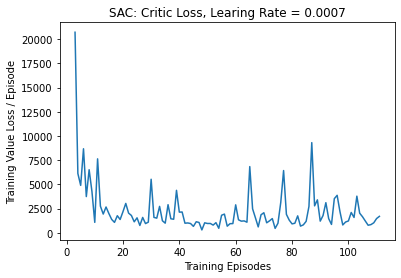

In [22]:
critic_loss = df['train/critic_loss']
plt.plot(critic_loss)
plt.xlabel('Training Episodes')
plt.ylabel('Training Value Loss / Episode')
plt.title('SAC: Critic Loss, Learing Rate = 0.0007')

As can be seen by the critic loss of this policy, which most closely approximates the value loss from the A2C model, the SAC model is able to learn an optimal policy over its training period much more effectively. 

Text(0.5, 1.0, 'SAC: Training Reward, Learing Rate = 0.00007')

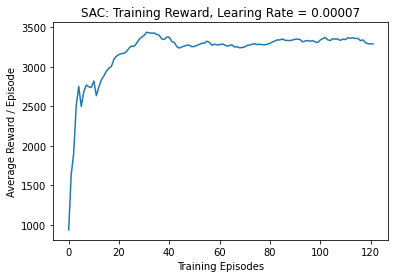

In [19]:
df = pd.read_csv("./logs/sac_train_0.00007.csv")
mean_rew = df['rollout/ep_rew_mean']
plt.plot(mean_rew)
plt.xlabel('Training Episodes')
plt.ylabel('Average Reward / Episode')
plt.title('SAC: Training Reward, Learing Rate = 0.00007')

The above chart show the training reward for SAC model training, but for a learning rate of 0.00007. Since the learning rate is smaller, the model is more stable in the way it learns compares to a learning rate of 0.0007. The downside of this maybe a longer training time taken to converge, but it does provide more stability. 

Text(0.5, 1.0, 'SAC: Critic Loss, Learing Rate = 0.00007')

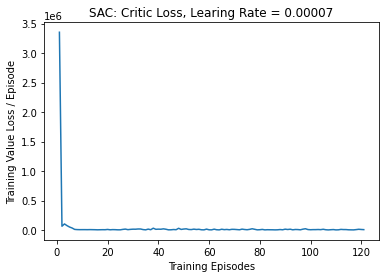

In [20]:
critic_loss = df['train/critic_loss']
plt.plot(critic_loss)
plt.xlabel('Training Episodes')
plt.ylabel('Training Value Loss / Episode')
plt.title('SAC: Critic Loss, Learing Rate = 0.00007')

Critic loss is similar for both learning rates for the SAC model. 

## Evaluation Results

The evaluation for the Soft Actor Critic is shown below, based on the evaluation data resulting from the above code portion saved to a csv file for the test run. The evaluation focuses on the reward collected over a period of one (1) week. 

Text(0, 0.5, '# of trips (shifted demand)')

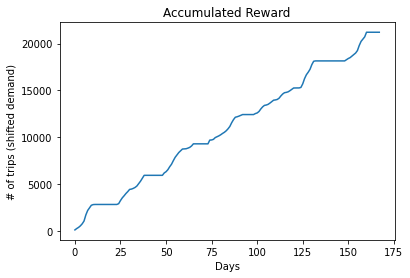

In [25]:
df = pd.read_csv("./logs/results_sac.csv")

rew = df['reward']
ful = df['fulfilled']
bud = df['budget']
dem = df['demand']
sup = df['supply']

def norm(data):
    return (data)/(max(data)-min(data))

rew.cumsum().plot()
plt.title('Accumulated Reward')
plt.xlabel('Days')
plt.ylabel('# of trips (shifted demand)')


The above plot shows the accumulated reward over one week. THe vertical axis represents the sum total # of trips that are fulfilled by the operator that are in excess of supply at each zone.  

Text(0.5, 0, 'Days')

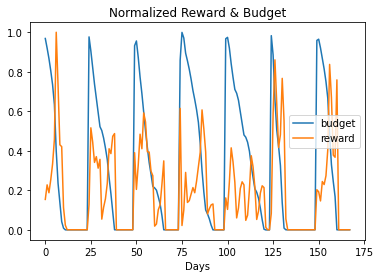

In [26]:

plt.plot(norm(bud), label='budget')
plt.plot(norm(rew), label='reward')
plt.title('Normalized Reward & Budget')
plt.legend()
plt.xlabel('Days')

The above chart shows the normalized budget and reward comparison over each 7 day period. As can be seen as the budget slowly decreases overtime due to the incentives offered, the reward goes to zero as well since the budget has run out. This shows that sufficient budget needs to be allocated in order to meet the overall excess demand, this can be experimentally determined based on the maximum demand in any period and seeing at what point the training rewards stop increasing.  

Text(0, 0.5, '# of Bikes / Trips')

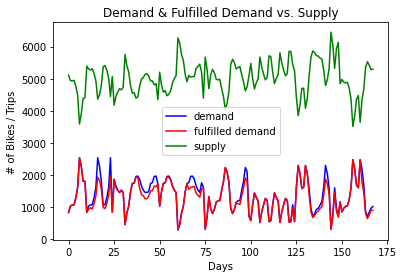

In [27]:
plt.plot(dem, "-b", label='demand')
plt.plot(ful, "-r", label='fulfilled demand')
plt.plot(sup, "-g", label='supply')
plt.title('Demand & Fulfilled Demand vs. Supply')
plt.xlabel('Days')
plt.legend()
plt.ylabel('# of Bikes / Trips')


The above chart shows the demand curve vs the fulfilled demand curve over the evaluation period. As can be see the model is able to meet the excess demand in almost all cases. The cases where the excess demand can't be met is either the budget running out or the cost being unacceptable for the user in the terms of the nearest zones being too far to walk too. 

In [40]:
print(rew.sum())

21213.0


The total amount of extra trips filled is 21,213 over a period of 7 days. As can be seen in the above charts, the complete budget of \$3000 was used up for each day, meaning a total of \$21,000 was used to fulfill the additional demand. However, this represents the overall cost. On average however, each trip had a cost of approximately $1, so assuming that each trip is priced a around $3 for the bikeshare system, there is still an increase in revenue and profit as a result of utilizing this scheme. 